[AT_TSALET_ALL 파일 전처리 코드](https://dacon.io/competitions/official/235801/codeshare/3233?page=1&dtype=recent)

## Overview

# 품목 : 토마토,  포도(캠벨얼리, 샤인마스캇)
컬리 : 토마토, 감귤, 사과, 포도, 배, 자두

데이터 수집 기간 : 2016년 1/1 ~ 2020년 9/28

## 주제:  농산물 품목별로 가격 변동 예측 모델 구현

### 과제 선정 배경
코로나 사태가 지속되면서 온라인 시장이 급증하여 가격 변동 예측을 통해 필요한 상품을 필요한 주기에 적정가에 구매하여 구매 비용 및 폐기율 낮춰 생산량 조절


### 과제 주요 내용
- 농산물 가격은 추측이 어려운 경향이 있음. 기격에 영향을 미치는 요인으로 거래량, 기상, 가격,사회적인 이슈, 물가 상승률, 거래량, 유가, 생산량, 해외 수입량, 재배 면적 등 다양하지만, 그중 기상, 유가, 가격, 거래량 데이터를 이용. 해당 데이터들을 수집하여 전처리, 이상치 탐지, 정규화 등의 과정을 거친 뒤, 회귀 기법의 머신러닝 모델 및 딥러닝(LSTM)을 이용하여 모델을 학습하고 예측한다.
- 주기는 1, 2, 4주로 예측
- 이번 프로젝트에서는 배추, 무, 양파, 건고추, 마늘, 대파, 얼갈이배추, 양배추, 깻잎, 시금치, 미나리, 당근, 파프리카, 새송이, 팽이버섯, 토마토, 청상추, 백다다기, 애호박, 캠벨얼리, 샤인마스캇 총 21개의 작물에 대하여 가격 예측을 진행한다.
- 수요예측 -> 계획 생산 -> 좋은 품질을 연간 균일, 합리적인 가격

### 과제 목표
- 마켓컬리 '폐기율 0.1%' 도전, 고객의 성향이나 맥락, 상품 특성을 고려해 적절한 시기에 상품을 추천함으로써 고객이 원하는 상품을 빠르고 쉽게 찾아서 주문할 수 있도록 지원하기위해 가격 예측이 필요함
- 입력받은 일자의 1주 뒤, 2주 뒤, 4주 뒤의 가격을 예측하는 것을 목표로 한다. 예를 들어, 2022년 10월 24일의 데이터를 입력으로 한다면, 10월 31일, 11월 1일, 11월 14일의 가격을 수치형으로 예측한다. 모델의 성능 평가 지표는 농산물마다 가격 범위 차이가 큰 점을 반영하여 NMAE(Normalized Mean Absolute Error)를 사용하며, 해당 값이 0.2가 넘지 않게 하는 것을 목표로 한다.

### 평가지표 
**RMSE(Root Mean Squared Error)**
RMSE의 경우 MSE는 제곱을 하기 때문에 MAE와는 다르게 모델의 예측값과 실제값 차이의 면적의 합이다. 이런 차이로 특이값이 존재하면 수치가 많이 늘어나며 특이치에 민감하다는 단점을 보완한 RMSE를 사용하면 오류 지표를 실제 값과 유사한 단위로 다시 변환하여 해석에 용이함.

[X] RMSE(평가지표) 예측 주기 정하기


# 라이브러리 불러오기

In [211]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
import tensorflow as tf
import keras
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Dataset

### 데이터 수집
이번 프로젝트에서는 2019년 1월 1일부터 2022년 6월 30일까지의 데이터를 학습용 데이터셋으로 수집하며, 2022년 7월 1일 + 1week부터 2022년 9월 30일 + 4week 까지를 테스트 데이터셋으로 수집한다.

#### 농산물 거래량 및 가격 데이터(train)
- 농넷에서 API Key를 발급받아 전국도매시장 거래정보 데이터를 수집한다.
- 농넷 | 농산물유통종합정보시스템: https://nongnet.or.kr
- 데이콘

#### 날씨 데이터(weather) 
- 공공데이터 포털에서 API Key를 발급받아 데이터 수집을 진행한다.
- 농촌진흥청 국립농업과학원 농업기상 데이터: https://www.data.go.kr/data/15078057/openapi.do

#### 유가 데이터(oil)
- 일간 휘발유, 경유의 거래 가격
- 오프넷 | https://www.opinet.co.kr/user/dopecomm/dopEcommSelect.do

#### 소비자 물가 지수 데이터(price_index)
- 가구에서 일상생활을 영위하기 위해 구입하는 상품과 서비스의 가격변동을 측정하기 위하여 작성되는 지수 일별 가격
- KOSIS| https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAA601_02&conn_path=I2

## 농산물, 유가, 소비자 물가지수 데이터 가져오기

In [2]:
# tain data 2016.01.01 ~ 2021.08.31
base = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트'

public_data =  base+'/data/public_data/'
private_data = base+'/data/private_data/'
sample_submission = pd.read_csv(base+'/data/sample_submission.csv')
submission = base+'./data/submission/'

private = pd.read_csv(private_data + 'private_data.csv')
# private.info()

import os
arr = os.listdir(base+'/data/public_data/train_AT_TSALET_ALL/')
print(arr)

['AT_TSALET_ALL_201807.csv', 'AT_TSALET_ALL_201608.csv', 'AT_TSALET_ALL_201609.csv', 'AT_TSALET_ALL_201806.csv', 'AT_TSALET_ALL_201812.csv', 'AT_TSALET_ALL_201804.csv', 'AT_TSALET_ALL_201810.csv', 'AT_TSALET_ALL_201811.csv', 'AT_TSALET_ALL_201805.csv', 'AT_TSALET_ALL_201801.csv', 'AT_TSALET_ALL_201802.csv', 'AT_TSALET_ALL_201803.csv', 'AT_TSALET_ALL_201904.csv', 'AT_TSALET_ALL_201910.csv', 'AT_TSALET_ALL_202001.csv', 'AT_TSALET_ALL_201911.csv', 'AT_TSALET_ALL_201905.csv', 'AT_TSALET_ALL_201907.csv', 'AT_TSALET_ALL_201708.csv', 'AT_TSALET_ALL_202003.csv', 'AT_TSALET_ALL_202002.csv', 'AT_TSALET_ALL_201709.csv', 'AT_TSALET_ALL_201906.csv', 'AT_TSALET_ALL_201912.csv', 'AT_TSALET_ALL_201902.csv', 'AT_TSALET_ALL_202006.csv', 'AT_TSALET_ALL_202007.csv', 'AT_TSALET_ALL_201903.csv', 'AT_TSALET_ALL_201901.csv', 'AT_TSALET_ALL_202005.csv', 'AT_TSALET_ALL_202004.csv', 'AT_TSALET_ALL_201702.csv', 'AT_TSALET_ALL_202009.csv', 'AT_TSALET_ALL_202008.csv', 'AT_TSALET_ALL_201703.csv', 'AT_TSALET_ALL_2017

In [3]:
base_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/raw/'

train = pd.read_csv(base_path+'train.csv')
price_index = pd.read_csv(base_path+'/물가지수.csv', index_col=0)
oil = pd.read_csv(base_path+'/주유소_평균판매가격.csv', encoding='cp949')

display(train.shape)
display(price_index.shape)
display(oil.shape)

(1733, 44)

(1733, 1)

(1733, 5)

In [4]:
train = train[['date', '요일','토마토_거래량(kg)','토마토_가격(원/kg)', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)','샤인마스캇_거래량(kg)','샤인마스캇_가격(원/kg)']]
train

,date,요일,토마토_거래량(kg),토마토_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,토요일,30950.0,1621.0,880.0,2014.0,0.0,0.0
2,2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-04,월요일,291057.0,1834.0,2703.8,3885.0,0.0,0.0
4,2016-01-05,화요일,194626.5,1833.0,8810.0,2853.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1728,2020-09-24,목요일,142487.0,5587.0,504242.6,3620.0,283196.9,10940.0
1729,2020-09-25,금요일,152575.5,5596.0,479683.1,3618.0,303779.6,10844.0
1730,2020-09-26,토요일,176807.0,5262.0,521493.8,3691.0,313295.7,10636.0
1731,2020-09-27,일요일,910.0,3781.0,21717.0,3567.0,9734.0,10699.0


## 날씨 데이터 가져오기
api 이용

In [5]:
print(arr)

['AT_TSALET_ALL_201807.csv', 'AT_TSALET_ALL_201608.csv', 'AT_TSALET_ALL_201609.csv', 'AT_TSALET_ALL_201806.csv', 'AT_TSALET_ALL_201812.csv', 'AT_TSALET_ALL_201804.csv', 'AT_TSALET_ALL_201810.csv', 'AT_TSALET_ALL_201811.csv', 'AT_TSALET_ALL_201805.csv', 'AT_TSALET_ALL_201801.csv', 'AT_TSALET_ALL_201802.csv', 'AT_TSALET_ALL_201803.csv', 'AT_TSALET_ALL_201904.csv', 'AT_TSALET_ALL_201910.csv', 'AT_TSALET_ALL_202001.csv', 'AT_TSALET_ALL_201911.csv', 'AT_TSALET_ALL_201905.csv', 'AT_TSALET_ALL_201907.csv', 'AT_TSALET_ALL_201708.csv', 'AT_TSALET_ALL_202003.csv', 'AT_TSALET_ALL_202002.csv', 'AT_TSALET_ALL_201709.csv', 'AT_TSALET_ALL_201906.csv', 'AT_TSALET_ALL_201912.csv', 'AT_TSALET_ALL_201902.csv', 'AT_TSALET_ALL_202006.csv', 'AT_TSALET_ALL_202007.csv', 'AT_TSALET_ALL_201903.csv', 'AT_TSALET_ALL_201901.csv', 'AT_TSALET_ALL_202005.csv', 'AT_TSALET_ALL_202004.csv', 'AT_TSALET_ALL_201702.csv', 'AT_TSALET_ALL_202009.csv', 'AT_TSALET_ALL_202008.csv', 'AT_TSALET_ALL_201703.csv', 'AT_TSALET_ALL_2017

In [6]:
filename_list = arr
filename_list_2020 = []
for filename in filename_list:
    if '2020' in filename:
        filename_list_2020.append(filename)
        
path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/data/public_data/train_AT_TSALET_ALL/'
df_list = []
for filename in tqdm(filename_list_2020):
    df = pd.read_csv(path+filename)
    df_list.append(df)
    
data= pd.concat(df_list, sort= False).reset_index(drop=True)

100%|███████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.02s/it]


In [7]:
# 토마토
tomato = data[(data.PUM_NM == '토마토')]
tomato.SAN_NM.value_counts()

부산 강서구      180982
부산광역시        54934
강원도 철원군      40510
부산 중구        39503
경북 경주시       31134
             ...  
서울 도봉구           1
중국               1
충청북도 진천군         1
전라남도 나주시         1
태국               1
Name: SAN_NM, Length: 344, dtype: int64

In [8]:
# 캠벨얼리
grapes = data[(data.KIND_NM == '캠벨얼리') ]
grapes.SAN_NM.value_counts()

전북 남원시        41350
경상북도 상주시      22274
경기도 화성시       15445
경북 상주시        11344
충청북도 영동군      10552
              ...  
충청남도 예산군          1
경북 고령군            1
충청북도 청원군          1
경기 고양시 덕양구        1
인천 동구             1
Name: SAN_NM, Length: 237, dtype: int64

In [9]:
print(len(grapes[grapes.SAN_NM.str.contains('남원',na=True)]))
print(len(grapes[grapes.SAN_NM.str.contains('상주',na=True)]))

45823
34749


In [10]:
# 샤인머스캇
shine = data[(data.KIND_NM == '샤인마스캇') ]
shine.SAN_NM.value_counts()

경북 김천시       22881
경상북도 김천시     21484
경북 영천시        7734
경상북도 상주시      4707
경상북도 영천시      3503
             ...  
경기 이천시           1
전라북도 완주군         1
경기 포천시           1
대구광역시 수성구        1
충남 연기군           1
Name: SAN_NM, Length: 153, dtype: int64

**주요 재배지 기상데이터 가져오기**
> '토마토': '부산시 강서구', <BR> 
'캠벨얼리': '전라북도 남원시',<BR>
'샤인마스캇': '경상북도 김천시'  <BR>
    => 김천시 날씨데이터 X -> 옆지역 '구미' 날씨데이터로 대체
   

In [306]:
weather = pd.read_csv(base_path+'weather.csv', encoding='cp949')
weather.shape

(5199, 62)

### 날씨 데이터 전처리
1. 결측비율이 80% 이상인 컬럼 drop
2. 부산에만 측정되는 항목 drop
3. 상관계수 0.8이상 칼럼 -> 비슷한 카테고리로 분류 
4. 날씨의 특성상 앞뒤 날씨의 영향을 받거나 혹은 비슷한 시기의 날씨의 특성과 비슷할 것으로 예상<br>
   따라서 결측치를 앞날의 데이터를 가져오는 것으로 결정

In [307]:
weather.drop(columns=['지점'], inplace=True)

In [308]:
# 1. 결측비율이 80% 이상인 컬럼 drop
weather.columns[np.sum(weather.isna()/len(weather))  > 0.8]
weather.drop(columns=['강수 계속시간(hr)', '10분 최다강수량 시각(hhmi)', '1시간 최다 강수량 시각(hhmi)',
       '일 최심신적설(cm)', '일 최심신적설 시각(hhmi)', '일 최심적설(cm)', '일 최심적설 시각(hhmi)',
       '합계 3시간 신적설(cm)', '9-9강수(mm)', '기사', '안개 계속시간(hr)'], inplace=True)

In [309]:
# 2. 부산시만 측정되는 항목 제외
weather.drop(columns=['평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)',
       '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)',
       '1.0m 지중온도(°C)', '1.5m 지중온도(°C)', '3.0m 지중온도(°C)', '5.0m 지중온도(°C)'], inplace=True)

In [310]:
weather.shape

(5199, 41)

In [311]:
# 결측치 있는 컬럼 23개
weather.columns[weather.isnull().sum() > 0]

Index(['평균기온(°C)', '최저기온(°C)', '10분 최다 강수량(mm)', '1시간 최다강수량(mm)', '일강수량(mm)',
       '평균 풍속(m/s)', '풍정합(100m)', '최다풍향(16방위)', '평균 이슬점온도(°C)', '평균 상대습도(%)',
       '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최저 해면기압(hPa)',
       '평균 해면기압(hPa)', '합계 일조시간(hr)', '1시간 최다일사 시각(hhmi)', '1시간 최다일사량(MJ/m2)',
       '합계 일사량(MJ/m2)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '합계 대형증발량(mm)',
       '합계 소형증발량(mm)'],
      dtype='object')

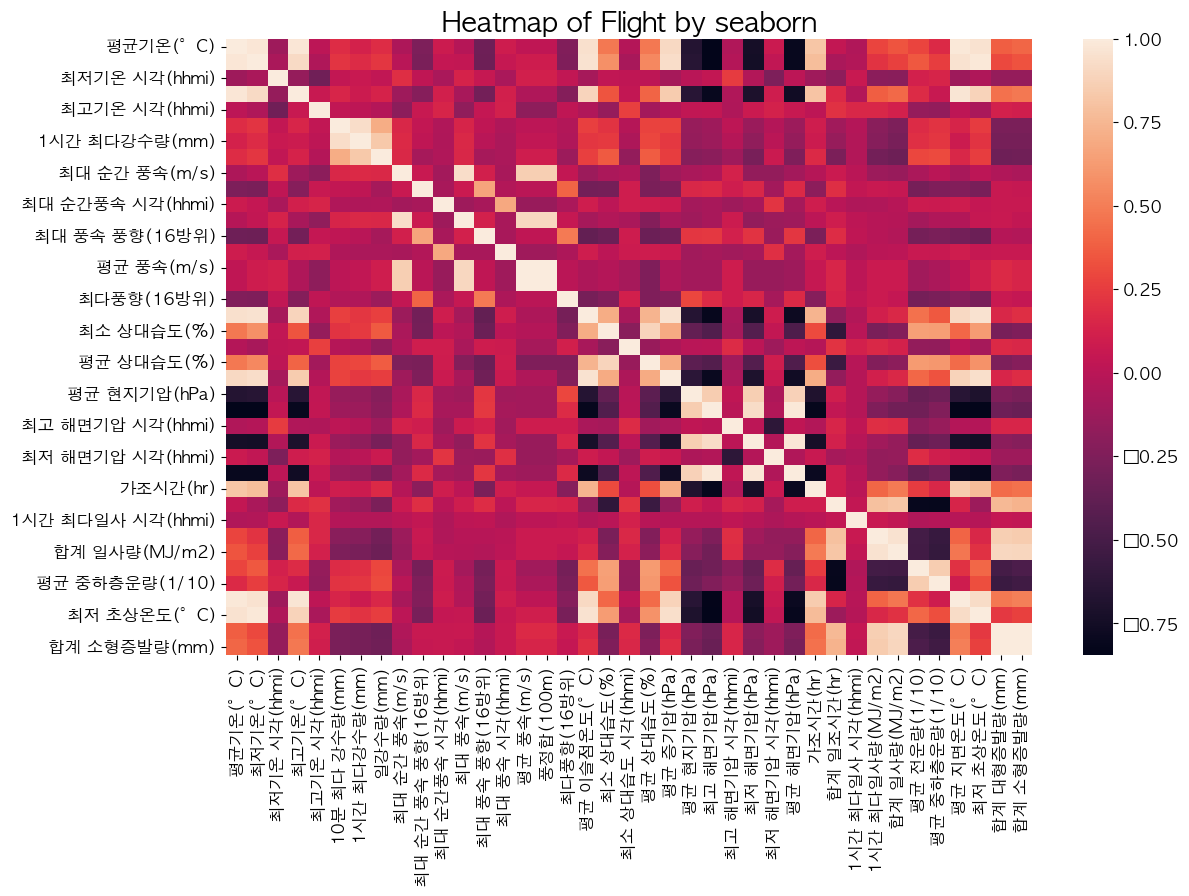

In [312]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = (13, 8)

weather_corr = weather.corr()
ax = sns.heatmap(weather_corr)
plt.title('Heatmap of Flight by seaborn', fontsize=20)
plt.show()

In [313]:
weather.columns

Index(['지점명', '일시', '평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)',
       '최고기온 시각(hhmi)', '10분 최다 강수량(mm)', '1시간 최다강수량(mm)', '일강수량(mm)',
       '최대 순간 풍속(m/s)', '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)', '최대 풍속(m/s)',
       '최대 풍속 풍향(16방위)', '최대 풍속 시각(hhmi)', '평균 풍속(m/s)', '풍정합(100m)',
       '최다풍향(16방위)', '평균 이슬점온도(°C)', '최소 상대습도(%)', '최소 상대습도 시각(hhmi)',
       '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)',
       '최고 해면기압 시각(hhmi)', '최저 해면기압(hPa)', '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)',
       '가조시간(hr)', '합계 일조시간(hr)', '1시간 최다일사 시각(hhmi)', '1시간 최다일사량(MJ/m2)',
       '합계 일사량(MJ/m2)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)',
       '최저 초상온도(°C)', '합계 대형증발량(mm)', '합계 소형증발량(mm)'],
      dtype='object')

In [314]:
# 3. 상관계수 0.8이상 칼럼 제거 또는 비슷한 카테고리로 분류
weather.drop(columns=['최저기온(°C)', '최고기온(°C)', '평균 이슬점온도(°C)' ,'평균 증기압(hPa)','가조시간(hr)','평균 지면온도(°C)','최대 순간 풍속 풍향(16방위)','최다풍향(16방위)',
       '최저 초상온도(°C)','10분 최다 강수량(mm)', '1시간 최다강수량(mm)','풍정합(100m)','평균 증기압(hPa)', '최고 해면기압(hPa)', '1시간 최다일사 시각(hhmi)', '1시간 최다일사량(MJ/m2)',
       '최고 해면기압 시각(hhmi)', '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)','최저 초상온도(°C)','합계 대형증발량(mm)', '합계 소형증발량(mm)'], inplace=True)

In [315]:
weather.loc[(weather['평균기온(°C)'] > 0 )&( weather['지점명'].str.contains('남원', na=True)), '지점명']

1734    남원
1735    남원
1736    남원
1737    남원
1738    남원
        ..
3461    남원
3462    남원
3463    남원
3464    남원
3465    남원
Name: 지점명, Length: 1539, dtype: object

In [316]:
# null 앞 또는 뒤 데이터로 대체

weather = weather.fillna(method='ffill')

In [319]:
weather.isna().sum()

지점명                 0
일시                  0
평균기온(°C)            0
최저기온 시각(hhmi)       0
최고기온 시각(hhmi)       0
일강수량(mm)            4
최대 순간 풍속(m/s)       0
최대 순간풍속 시각(hhmi)    0
최대 풍속(m/s)          0
최대 풍속 풍향(16방위)      0
최대 풍속 시각(hhmi)      0
평균 풍속(m/s)          0
최소 상대습도(%)          0
최소 상대습도 시각(hhmi)    0
평균 상대습도(%)          0
평균 현지기압(hPa)        0
최저 해면기압(hPa)        0
합계 일조시간(hr)         0
합계 일사량(MJ/m2)       0
평균 전운량(1/10)        0
평균 중하층운량(1/10)      0
dtype: int64

In [349]:
weather.loc[weather['일시'].str.contains('2016-01-0', na = False)&(weather['지점명'].str.contains('부산', na = False)),'일강수량(mm)']

0    0.0
1    0.0
2    0.0
3    0.0
4    0.2
5    0.2
6    0.2
7    0.2
8    0.2
Name: 일강수량(mm), dtype: float64

In [347]:
# 2016-01-01 날씨 뉴스를 기준으로 강수량 없음 확인
weather.loc[weather['일강수량(mm)'].isna(), '일강수량(mm)'] = 0.0

### 최종 날씨 데이터 결측치 확인

In [350]:
weather.isna().sum()

지점명                 0
일시                  0
평균기온(°C)            0
최저기온 시각(hhmi)       0
최고기온 시각(hhmi)       0
일강수량(mm)            0
최대 순간 풍속(m/s)       0
최대 순간풍속 시각(hhmi)    0
최대 풍속(m/s)          0
최대 풍속 풍향(16방위)      0
최대 풍속 시각(hhmi)      0
평균 풍속(m/s)          0
최소 상대습도(%)          0
최소 상대습도 시각(hhmi)    0
평균 상대습도(%)          0
평균 현지기압(hPa)        0
최저 해면기압(hPa)        0
합계 일조시간(hr)         0
합계 일사량(MJ/m2)       0
평균 전운량(1/10)        0
평균 중하층운량(1/10)      0
dtype: int64

### 농산지에 맞게 날씨 데이터 분리 (부산/구미/남원 분리해서 저장)

In [351]:
busan = weather[weather.지점명 == '부산'] 
gumi = weather[weather.지점명 == '구미']
namwon = weather[weather.지점명 == '남원']

In [352]:
print(busan.shape)
print(gumi.shape)
print(namwon.shape)

(1733, 21)
(1733, 21)
(1733, 21)


In [353]:
processed_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/processed/'

busan.to_csv(processed_path+'busan_weather.csv', index=False)
gumi.to_csv(processed_path+'gumi_weather.csv', index=False)
namwon.to_csv(processed_path+'namwon_weather.csv', index=False)

In [401]:
weather.to_csv(processed_path+'weather.csv', index = False)

# 데이터 합치기

> 요일을 기준으로 train(농산물) + price_index(소비자물가지수) + oil(가솔린) + weather(날씨)  : 3개,.csv에 저장 (토마토, (캠벨얼리, 샤인마스캇))

In [376]:
# 소비자 물가 지수 농산물 데이터와 합치기
train_df = pd.concat([train, price_index['지수']],axis=1)
train_df.shape

(1733, 9)

In [383]:
train_df.rename(columns={'지수':'소비자물가지수'})

In [381]:
# 유가 데이터 합치기
oil.drop(columns=['구분'], inplace=True)
train_df = pd.concat([train_df, oil],axis=1)
train_df.shape

(1733, 13)

In [386]:
# 일시를 기준으로 합치기위해 컬럼 이름 변경

busan = busan.rename(columns={'일시' : 'date'})
gumi = gumi.rename(columns={'일시' : 'date'})
namwon = namwon.rename(columns={'일시' : 'date'})

In [388]:
# 토마토 (부산)
tomato_df = train_df.merge(busan, on='date', how='left')

# 캠벨얼리 (남원)
grape_df = train_df.merge(namwon, on='date', how='left')

# 샤인머스캇(구미)
shinemuscat_df = train_df.merge(gumi, on='date', how='left')

In [394]:
display(tomato_df.shape)
print()
display(grape_df.shape)
print()
display(shinemuscat_df.shape)

(1733, 29)

(1733, 29)

(1733, 29)

In [393]:
# 토마토 (부산) 데이터에서 캠벨얼리, 샤인머스캇 항목 제거
tomato_df.drop(columns=['캠벨얼리_거래량(kg)','캠벨얼리_가격(원/kg)', '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)'], inplace=True)

# 캠벨얼리 (남원)데이터에서 토마토, 샤인머스캇 항목 제거
grape_df.drop(columns=['토마토_거래량(kg)', '토마토_가격(원/kg)', '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)'], inplace=True)

# 샤인머스캇(구미)데이터에서 캠벨얼리, 토마토 항목 제거
shinemuscat_df.drop(columns=['캠벨얼리_거래량(kg)','캠벨얼리_가격(원/kg)','토마토_거래량(kg)', '토마토_가격(원/kg)'], inplace=True)

In [395]:
display(tomato_df.head(2))
display(tomato_df.shape)
print()
display(grape_df.head(2))
display(grape_df.shape)
print()
display(shinemuscat_df.head(2))
display(shinemuscat_df.shape)

,date,요일,토마토_거래량(kg),토마토_가격(원/kg),지수,고급휘발유,보통휘발유,자동차용경유,실내등유,지점명,...,평균 풍속(m/s),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 현지기압(hPa),최저 해면기압(hPa),합계 일조시간(hr),합계 일사량(MJ/m2),평균 전운량(1/10),평균 중하층운량(1/10)
0,2016-01-01,금요일,0.0,0.0,95.232,1780.99,1407.15,1188.71,835.38,부산,...,4.3,33.0,1229,52.1,1021.3,1027.5,9.3,11.44,1.4,0.0
1,2016-01-02,토요일,30950.0,1621.0,95.232,1781.69,1405.98,1187.91,834.11,부산,...,4.0,52.0,1046,62.9,1015.1,1020.6,5.1,6.86,4.6,2.3


(1733, 29)

,date,요일,캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),지수,고급휘발유,보통휘발유,자동차용경유,실내등유,지점명,...,평균 풍속(m/s),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 현지기압(hPa),최저 해면기압(hPa),합계 일조시간(hr),합계 일사량(MJ/m2),평균 전운량(1/10),평균 중하층운량(1/10)
0,2016-01-01,금요일,0.0,0.0,95.232,1780.99,1407.15,1188.71,835.38,남원,...,1.3,45.0,1417,73.3,1015.3,1029.2,7.9,21.33,2.3,0.6
1,2016-01-02,토요일,880.0,2014.0,95.232,1781.69,1405.98,1187.91,834.11,남원,...,0.9,52.0,1440,77.8,1008.1,1021.3,2.4,21.33,2.3,0.6


(1733, 29)

,date,요일,샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg),지수,고급휘발유,보통휘발유,자동차용경유,실내등유,지점명,...,평균 풍속(m/s),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 현지기압(hPa),최저 해면기압(hPa),합계 일조시간(hr),합계 일사량(MJ/m2),평균 전운량(1/10),평균 중하층운량(1/10)
0,2016-01-01,금요일,0.0,0.0,95.232,1780.99,1407.15,1188.71,835.38,구미,...,0.8,45.0,1326,79.3,1024.9,1028.3,7.1,21.33,2.1,0.0
1,2016-01-02,토요일,0.0,0.0,95.232,1781.69,1405.98,1187.91,834.11,구미,...,0.6,48.0,1505,83.9,1017.9,1021.3,4.2,21.33,2.1,0.0


(1733, 29)

In [397]:
# 토마토 (부산) 저장
tomato_df.to_csv(processed_path+'tomato.csv', index = False)

# 캠벨얼리 (남원) 저장
grape_df.to_csv(processed_path+'grape.csv', index = False)

# 샤인머스캇(구미) 저장
shinemuscat_df.to_csv(processed_path+'shinemuscat.csv', index = False)